<center><img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200"/></center>

<center><font size=10>Generative AI for Business Applications</center></font>
<center><font size=6>Introduction to LLMOps</center></font>

<center><img src="https://i.ibb.co/pBF9nKpf/apple.png" width="720"></center>

<center><font size=6>Apple HBR Report Document Q&A</center></font>

# Problem Statement

## Business Context

As organizations grow and scale, they are often inundated with large volumes of data, reports, and documents that contain critical information for decision-making. In real-world business settings, such as venture capital firms like Andreesen Horowitz, business analysts are required to sift through large datasets, research papers, or reports to extract relevant information that impacts strategic decisions.

For instance, consider that you've just joined Andreesen Horowitz, a renowned venture capital firm, and you are tasked with analyzing a dense report like the Harvard Business Review's **"How Apple is Organized for Innovation."** Going through the report manually can be extremely time-consuming as the size and complexity of these report increases. However, by using **Semantic Search** and **Retrieval-Augmented Generation (RAG)** models, you can significantly streamline this process.

Imagine having the capability to directly ask questions like, “How does Apple structure its teams for innovation?” and get immediate, relevant answers drawn from the report. This ability to extract and organize specific insights quickly and accurately enables you to focus on higher-level analysis and decision-making, rather than being bogged down by information retrieval.

## Objective

The goal is to develop a RAG application that helps business analysts efficiently extract key insights from extensive reports, such as “How Apple is Organized for Innovation.”

Specifically, the system aims to:

- Answer user queries by retrieving relevant content directly from lengthy documents.

- Support natural-language interaction without requiring a full manual read-through.

- Act as an intelligent assistant that streamlines the report analysis process.

Through this solution, analysts can save time, improve productivity, and make faster, more informed strategic decisions

## Data Description

**How Apple is Organized for Innovation** - An article of 11 pages in pdf format

# Installing and Importing the Necessary Libraries

In [1]:
# Install Required Libraries for RAG + LLMOps
!pip install -q langchain_community==0.3.27 \
              langchain==0.3.27 \
              chromadb==1.0.15 \
              pymupdf==1.26.3 \
              tiktoken==0.9.0 \
              ragas==0.3.0 \
              datasets==4.0.0 \
              evaluate==0.4.5 \
              mlflow==3.4.0 \
              prefect==3.4.22 \
              openai==1.109.1 \
              pyngrok==7.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.4 MB/s eta 0:00:00


* **`mlflow`** - Tracks experiments, logs parameters, metrics, and artifacts, enabling reproducibility and version control.
* **`prefect`** - Orchestrates and monitors workflows, allowing scheduling, retries, and observability of pipeline tasks.
* **`pyngrok`** - Creates a secure public URL (tunnel) to access locally hosted MLflow or Prefect UIs from anywhere.


**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

In [1]:
# Import core libraries
import os
import json
import time

# Import libraries for working with PDFs and OpenAI
from langchain.document_loaders import PyMuPDFLoader
from openai import OpenAI

# Import libraries for processing dataframes and text
import tiktoken
import pandas as pd

# Import LangChain components for data loading, chunking, embedding, and vector DBs
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# Import components to run evaluation on RAG pipeline outputs
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    LLMContextPrecisionWithoutReference,
)
from datasets import Dataset
from langchain_openai import ChatOpenAI



# LLMOps additions
from prefect import flow, task                                                  # Prefect enables workflow orchestration (task scheduling, retries, monitoring)
from concurrent.futures import ThreadPoolExecutor                               # Allows parallel execution of independent tasks (e.g., embedding multiple docs simultaneously)
import mlflow
from pathlib import Path
from pyngrok import ngrok
import subprocess


* **`prefect (flow, task)`** - Organizes and tracks all parts of your AI pipeline, making it easier to run, monitor, and manage every step reliably.
* **`ThreadPoolExecutor`** - Speeds up your AI pipeline by letting multiple tasks (like processing documents or generating answers) run at the same time.
* **`mlflow`** - Tracks experiments, parameters, outputs, and evaluation metrics.
* **`pathlib.Path`** - Handles file paths cleanly and consistently across systems.
* **`pyngrok.ngrok`** - Creates secure public URLs to access local services like MLflow UI.
* **`subprocess`** - Runs external commands from Python, e.g., starting MLflow UI.


## OpenAI and Ngrok Setup



> #### **Prerequisite**
> * Before running the below cell, make sure that **all required credentials and tokens are properly added to the config file**.
> * For **OpenAI Credentials**, the API key and base URL **are already provided to you by GL**. **Use the same values** in the config file to enable the notebook to access OpenAI services.
> * To get the ngrok authorization token, please go to this [link](https://dashboard.ngrok.com/authtokens), generate a new token, copy it, and paste it into the designated section of the config file.

In [2]:
# Load the JSON file and extract values
file_name = 'config_llmops.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    OPENAI_API_KEY = config.get("OPENAI_API_KEY")
    OPENAI_API_BASE = config.get("OPENAI_API_BASE")
    NGROK_AUTHTOKEN = config.get("NGROK_AUTHTOKEN")                             #This will be used later on while creating MLFlow UI


# Store API credentials in environment variables
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ["OPENAI_BASE_URL"] = OPENAI_API_BASE
os.environ["NGROK_AUTHTOKEN"] = NGROK_AUTHTOKEN

# Initialize OpenAI client
client = OpenAI()

# Retrieval Augmented Generation (RAG) Implementation

### **General Steps involved in RAG**
1. **Load a document and split it** - Take a PDF or other text and break it into smaller, manageable chunks.
2. **Convert chunks into embeddings** - Turn the text into numbers that the AI can understand and search.
3. **Retrieve relevant chunks** - When someone asks a question, find the most relevant pieces of text.
4. **Generate an answer** - Use the retrieved pieces as context to produce an answer.


### **What do we add with LLMOps?**

With LLMOps, we make the RAG system more **organized, trackable, and repeatable**:

* **Test different prompts** - Try variations of questions or instructions to see which gives the best answers.
* **Record prompts and settings** - Keep track of which prompt, parameters, or configurations were used for each question.
* **Evaluate answers** - Check answers for correctness and relevance using simple metrics.

We do this using **Prefect** and **MLflow**:

* **Prefect** - Think of this as a “task manager” for your AI pipeline. Each step in RAG (load, embed, retrieve, answer) becomes a **task**. Prefect runs these tasks in order, keeps an eye on them, and makes sure everything works smoothly.
* **MLflow** - This is like a “journal” for your experiments. Every time a task runs, MLflow records the input (like the prompt), the output (AI’s answer), and evaluation scores. Later, you can look back and see what worked best.


### **How do we put it all together?**

1. Wrap each RAG step as a **Prefect task** - this makes it easy to run, reuse, and monitor.
2. Connect tasks into a **Prefect workflow (flow)** - automates the whole process from start to finish.
3. Use **MLflow** inside these tasks - logs what went in, what came out, and how well it performed.

> In simple terms:
> **Prefect** organizes the work, and **MLflow** records the results. Together, they make your RAG pipeline **smarter, trackable, and easier to improve**.

### MLFlow Setup

Before building the RAG workflow, we need to set up an **experiment tracking system**.  


That's what **MLflow** does - it acts as our **central experiment tracker**, keeping a record of parameters, outputs, and metrics for every run.

In [3]:
# Persist logs
mlruns_path = Path("/content/llmops_mlflow")

# Set MLflow file tracking path
mlflow.set_tracking_uri(f"file:///{mlruns_path.resolve()}")
print("MLflow tracking URI:", mlflow.get_tracking_uri())

mlflow.set_experiment("LLMOps_Demo")

MLflow tracking URI: file:////content/llmops_mlflow


<Experiment: artifact_location='file:////content/llmops_mlflow/908928109588137490', creation_time=1760074219831, experiment_id='908928109588137490', last_update_time=1760074219831, lifecycle_stage='active', name='LLMOps_Demo', tags={}>

In the above code -

-  **`mlruns_path = Path("/content/llmops_mlflow")`**  Defines where experiment logs will be stored.  
   - Here, we're using a local path (`/content/llmops_mlflow`), which works well in Colab or a local setup.  
   - In production, this can point to a remote MLflow server or cloud-based tracking URI.

- **`mlflow.set_experiment("LLMOps_Demo")`**  Creates (or selects) an experiment called `"LLMOps_Demo"`.  
   - Each RAG run - for different prompt versions or configurations - will appear as a separate *run* under this experiment.

### Loading the Data

In [4]:
pdf_file = "/content/HBR_How_Apple_Is_Organized_For_Innovation.pdf"

### Split the Loaded PDF into Chunks for Further Processing

In a **normal RAG pipeline**, we can run the code for individual steps in the solution workflow directly without defining any specific, modular functions for each step in the workflow.

In the current scenario, where we want to build a **RAG pipeline with LLMOps (task orchestration and experimentation tracking)**, we'll **wrap the code in a function** and make it a **`prefect` task**.

* **Function** - Organizes the code into a reusable block, so we can run it anytime with different PDFs.
* **Task** - Let's `prefect` manage this step in a workflow: it can track progress, run automatically, retry if something fails, and connect with other steps in an orderly way.

> In simple terms, the function makes it reusable, and the task makes it **trackable and manageable** as part of an LLMOps workflow.

In [5]:
@task
def load_and_split_pdf(pdf_path):
    loader = PyMuPDFLoader(pdf_path)
    docs = loader.load()
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=20
    )
    chunks = splitter.split_documents(docs)

    if not chunks:
      raise ValueError("No document chunks found. Check your PDF or splitter.")

    return chunks

### Generate Embeddings and store them in a Vector Database

In [6]:
@task(cache_policy=None)
def create_vectorstore(chunks):
    embeddings = OpenAIEmbeddings(
    openai_api_key=OPENAI_API_KEY,
    openai_api_base=OPENAI_API_BASE
    )
    vectordb = Chroma.from_documents(chunks, embeddings)
    return vectordb.as_retriever(search_type='similarity',
                                      search_kwargs={'k': 5})

### Designing the System Prompt and Prompt Versioning

In LLMOps, we often want to test different configurations or inputs (like prompt versions) to see what works best. By defining multiple versions:

* Each version becomes a **separate experiment**, which can be tracked for inputs, outputs, and performance.
* This approach helps teams **evaluate, iterate, and optimize** their AI pipelines systematically.


In [7]:
system_prompt_1 = """You are an assistant whose job is to answer questions based on a provided context."""

In [8]:
system_prompt_2="""You are an assistant whose work is to give answers to questions with repect to a context.
User input will have the context required by you to answer user questions.

This context will begin with the token: ###Context.
The context contains references to specific portions of a document relevant to the user query.

User questions will begin with the token: ###Question.

Strictly answer only using the information provided in the ###Context.
Do not mention anything about the information in ###Context or the question in ###Question in your final answer.

If the answer to ###Question cannot be derived from the ###Context, just respond by saying "I don't know".

Remember that the answer to ###Question might not always be directly present in the information provided in the ###Context.
the answer can be indirectly derived from the information in ###Context."""

In [9]:
user_template="""Consider the following ###Context and ###Question

###Context
{context}

###Question
{question}

"""

In [10]:
# Define Multiple Prompt Versions

PROMPT_VERSIONS = {
    "v1": {
        "system": system_prompt_1,
        "user_template": user_template },
    "v2": {
        "system": system_prompt_2,
        "user_template": user_template }
}

def get_prompts(version="v1"):
    return PROMPT_VERSIONS.get(version, PROMPT_VERSIONS["v1"])


### Defining the function for generating responses




In [11]:
@task(cache_policy=None)
def generate_rag_response_task(user_input, retriever, prompt_version, k=5, max_tokens=500, temperature=0.3, top_p=0.95):
    prompts = get_prompts(prompt_version)
    qna_system_message = prompts["system"]
    qna_user_message_template = prompts["user_template"]

    # Retrieve relevant chunks
    relevant_chunks = retriever.get_relevant_documents(query=user_input, k=k)
    context_list = [d.page_content for d in relevant_chunks]

    if not context_list:
        return "No relevant context found.", []

    context_for_query = ". ".join(context_list)

    # Prepare user message
    user_message = qna_user_message_template.replace("{context}", context_for_query)
    user_message = user_message.replace("{question}", user_input)

    # Generate response
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": qna_system_message},
                {"role": "user", "content": user_message}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )
        response_text = response.choices[0].message.content.strip()
    except Exception as e:
        response_text = f"Error: {e}"

    return response_text, context_list

### Output Evaluation

In [12]:
@task
def evaluate_rag(outputs):
    from ragas import evaluate
    from ragas.metrics import Faithfulness, AnswerRelevancy
    from datasets import Dataset

    dataset = Dataset.from_dict(outputs)
    result = evaluate(
        dataset=dataset,
        metrics=[Faithfulness(), AnswerRelevancy()]
    )
    return result

# Prefect Flow and MLflow Tracking

In this pipeline, we combine all individual tasks into a **single automated workflow** using **Prefect** for orchestration and **MLflow** for experiment tracking.

**Step-by-step explanation:**

1. **Load and Split PDF**
   - Reads the PDF document and breaks it into smaller chunks that the AI model can process efficiently.

2. **Create Vector Database (Retriever)**
   - Stores the chunks in a searchable format so the model can quickly find relevant context when answering questions.

3. **Loop Through Prompt Versions**
   - Tests multiple prompt designs (e.g., `v1`, `v2`) to see which version produces the best answers.

4. **Generate Answers using Prefect Tasks**
   - Each prompt version runs as a **Prefect task**, which allows structured execution, tracking, and retries if needed.

5. **Start MLflow Run for Each Version**
   - Creates a separate run for each prompt version under the main experiment, ensuring all inputs and outputs are tracked.

6. **Log Parameters, Answers, and Contexts**
   - MLflow records the prompt version, question, generated answer, and the context used, making the workflow fully traceable.

7. **Prepare Outputs for Evaluation**
   - Packages the question, answer, and context for evaluation using metrics like correctness, relevance, and faithfulness.

8. **Run Evaluation and Log Metrics**
   - Evaluates the answer automatically and logs numeric metrics to MLflow, enabling easy comparison between prompt versions.

9. **Store and Print Results**
   - Collects answers and evaluation results for all versions, prints them for inspection, and returns all results at the end.

In [13]:
# Define the main pipeline flow using Prefect's @flow decorator
@flow(name="rag_with_versions_and_evaluation")
def rag_pipeline_with_eval(pdf_path, question, versions=["v1", "v2"]):
    # Step 1: Load and process the input PDF document
    chunks = load_and_split_pdf(pdf_path)

    # Step 2: Create a vector database (retriever) from these chunks
    retriever = create_vectorstore(chunks)

    # A list to store results for all prompt versions
    all_results = []

    # Step 3: Loop through each prompt version to compare results
    for prompt_version in versions:

        # Step 4: Generate an answer using the selected prompt version
        # Each call is treated as a Prefect task for better orchestration and tracking
        response_future = generate_rag_response_task.submit(
            user_input=question, retriever=retriever, prompt_version=prompt_version
        )

        # WaitS for the task to complete and get the output (answer + context used)
        answer, context_list = response_future.result()

        # Step 5: Start an MLflow run for this prompt version
        # Each version gets its own tracked run under the main experiment
        with mlflow.start_run(run_name=f"RAG_{prompt_version}", nested=True):

            # Log key parameters - helps us trace which version and question were used
            mlflow.log_param("prompt_version", prompt_version)
            mlflow.log_param("question", question)
            mlflow.log_param("prompt_length", len(prompt_version))
            mlflow.log_param("answer_length", len(answer))

            # Save the generated answer and the context it was based on
            mlflow.log_text(answer, f"answer_{prompt_version}.txt")
            mlflow.log_text("\n".join(context_list), f"context_{prompt_version}.txt")
            mlflow.set_tag("mlflow.project.type", "llm/prompt_engineering")

            # Step 6: Prepare outputs for evaluation (faithfulness, relevance, etc.)
            outputs = {
                "question": [question],
                "answer": [answer],
                "contexts": [context_list]
            }

            # Step 7: Run the RAGAS evaluation to measure how good the answer is
            eval_result = evaluate_rag(outputs)

            # Step 8: Convert evaluation results into MLflow metrics for easy comparison
            try:
                df = eval_result.to_pandas()
                metrics_dict = {}

                # Extract only numeric values (since MLflow metrics must be numbers)
                for k, v in df.iloc[0].to_dict().items():
                    val = v[0] if isinstance(v, list) and isinstance(v[0], (int, float)) else v
                    if isinstance(val, (int, float)):
                        metrics_dict[k] = float(val)

                # Log metrics to MLflow if found
                if metrics_dict:
                    mlflow.log_metrics(metrics_dict)
                    print(f"Logged Evaluation Metrics for {prompt_version}:", metrics_dict)

            except Exception as e:
                print(f"Could not log metrics for {prompt_version}:", e)

            # Store all results for later comparison
            all_results.append((prompt_version, answer, eval_result))

            # Print the answer for this version
            print(f"\n--- Version {prompt_version} ---\nAnswer:\n{answer}\n")

    # Step 9: Return results for all prompt versions
    return all_results


# Question Answering using RAG

### Question 1: How did Apple's design team influence the final version of portrait mode on the iPhone?



In [14]:
question_1 = "How did Apple’s design team influence the final version of portrait mode on the iPhone?"
rag_answer_1 = rag_pipeline_with_eval(pdf_file, question_1)

print("\n\n--- Prompt Version Outputs + Evaluation ---")
for version, answer, eval_result in rag_answer_1:
    print(f"\n{version} answer:\n{answer}")
    print(f"Evaluation metrics for {version}:\n{eval_result}\n")

INFO:prefect:Starting temporary server on http://127.0.0.1:8546
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.
INFO:prefect.flow_runs:Beginning flow run 'spicy-ermine' for flow 'rag_with_versions_and_evaluation'
INFO:prefect.task_runs:Finished in state Completed()
/tmp/ipython-input-4061731708.py:3: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(
INFO:prefect.task_runs:Finished in state Completed()
/tmp/ipython-input-1899371618.py:8: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:prefect.task_runs:Finished in state Completed()


Logged Evaluation Metrics for v1: {'faithfulness': 1.0, 'answer_relevancy': 0.9976994599679646}

--- Version v1 ---
Answer:
Apple's design team influenced the final version of portrait mode on the iPhone by advocating for a "live preview" feature that would allow users to see the effect of the portrait mode before taking a photo. Initially, the camera team had designed the feature to show the effect only after the photo was taken. However, Johnnie Manzari from the design team demonstrated the live preview concept, which led the camera team to realize its importance for enhancing user experience. 

The collaboration between the design team and the camera team resulted in a successful implementation of this feature, despite initial doubts about its feasibility. This change was crucial in making portrait mode a central aspect of Apple’s marketing for the iPhone 7 Plus, ultimately contributing to its popularity among users. Additionally, the design team helped reassess quality standards by

INFO:prefect.task_runs:Finished in state Completed()


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:prefect.task_runs:Finished in state Completed()
INFO:prefect.flow_runs:Finished in state Completed()


Logged Evaluation Metrics for v2: {'faithfulness': 1.0, 'answer_relevancy': 0.9775352816388394}

--- Version v2 ---
Answer:
Apple's design team influenced the final version of portrait mode by advocating for a "live preview" feature that allowed users to see the effect of the portrait mode before taking a photo. This pushback led to a demo that demonstrated the necessity of this feature, prompting the camera team to work towards implementing it despite initial doubts about feasibility. The collaboration between the design and camera teams ultimately contributed to a superior user experience, which was central to the marketing of the iPhone 7 Plus.



--- Prompt Version Outputs + Evaluation ---

v1 answer:
Apple's design team influenced the final version of portrait mode on the iPhone by advocating for a "live preview" feature that would allow users to see the effect of the portrait mode before taking a photo. Initially, the camera team had designed the feature to show the effect only a

### Question 2: List down the three leadership characteristics in bulleted points and explain each one of the characteristics under two lines.

In [15]:
question_2 = "List down the three leadership characteristics in bulleted points and explain each one of the characteristics under two lines."
rag_answer_2 = rag_pipeline_with_eval(pdf_file, question_2)

print("\n\n--- Prompt Version Outputs + Evaluation ---")
for version, answer, eval_result in rag_answer_2:
    print(f"\n{version} answer:\n{answer}")
    print(f"Evaluation metrics for {version}:\n{eval_result}\n")

INFO:prefect.flow_runs:Beginning flow run 'olivine-lion' for flow 'rag_with_versions_and_evaluation'
INFO:prefect.task_runs:Finished in state Completed()
INFO:prefect.task_runs:Finished in state Completed()
INFO:prefect.task_runs:Finished in state Completed()


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:prefect.task_runs:Finished in state Completed()


Logged Evaluation Metrics for v1: {'faithfulness': 1.0, 'answer_relevancy': 0.801772907811884}

--- Version v1 ---
Answer:
- **Deep Expertise**: Apple prioritizes having experts manage their respective domains rather than general managers. This ensures that decisions are made by those with the most relevant knowledge and skills.

- **Immersion in the Details**: Leaders at Apple are expected to understand the intricacies of their functions thoroughly, enabling quick and informed decision-making. This attention to detail is crucial for maintaining high standards in product development.

- **Willingness to Collaboratively Debate**: Apple fosters an environment where leaders engage in open discussions across functions. This collaborative approach enhances innovation by integrating diverse perspectives and expertise in the decision-making process.



INFO:prefect.task_runs:Finished in state Completed()


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:prefect.task_runs:Finished in state Completed()
INFO:prefect.flow_runs:Finished in state Completed()


Logged Evaluation Metrics for v2: {'faithfulness': 0.9230769230769231, 'answer_relevancy': 0.8311533301158719}

--- Version v2 ---
Answer:
- **Deep Expertise**: Leaders at Apple are expected to have specialized knowledge in their respective fields, allowing them to effectively manage and contribute to their functions. This ensures that experts lead experts, enhancing problem-solving and innovation.

- **Immersion in the Details**: Leaders should understand the intricacies of their organization at multiple levels, facilitating quick and informed decision-making. This deep knowledge helps in maintaining high standards and attention to detail in product development.

- **Willingness to Collaboratively Debate**: Apple encourages open discussions among specialists from various teams to foster innovation. This collaborative approach ensures that diverse perspectives are considered, leading to better product outcomes.



--- Prompt Version Outputs + Evaluation ---

v1 answer:
- **Deep Experti

### Question 3: How does Apple's use of 'squircles' reflect its leadership's immersion in detail?

In [16]:
question_3 = "How does Apple’s use of ‘squircles’ reflect its leadership’s immersion in detail?"
rag_answer_3 = rag_pipeline_with_eval(pdf_file, question_3)

print("\n\n--- Prompt Version Outputs + Evaluation ---")
for version, answer, eval_result in rag_answer_3:
    print(f"\n{version} answer:\n{answer}")
    print(f"Evaluation metrics for {version}:\n{eval_result}\n")

INFO:prefect.flow_runs:Beginning flow run 'abstract-crab' for flow 'rag_with_versions_and_evaluation'
INFO:prefect.task_runs:Finished in state Completed()
INFO:prefect.task_runs:Finished in state Completed()
INFO:prefect.task_runs:Finished in state Completed()


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:prefect.task_runs:Finished in state Completed()


Logged Evaluation Metrics for v1: {'faithfulness': 1.0, 'answer_relevancy': 0.9067679145874221}

--- Version v1 ---
Answer:
Apple's use of 'squircles' reflects its leadership's immersion in detail by demonstrating a commitment to precision and quality in product design. The leadership at Apple insists on continuous curves rather than the standard method of using an arc of a circle, which results in abrupt transitions. This choice is not merely aesthetic; it has practical implications for the product's performance, such as producing softer highlights and minimizing light reflection.

The process of creating 'squircles' requires extremely precise manufacturing tolerances, showcasing the depth of knowledge and attention to detail that Apple leaders possess. They are deeply involved in the specifics of product design, understanding how even subtle differences can impact the overall user experience. This level of detail is not just delegated to lower-level employees; it is a central concern

INFO:prefect.task_runs:Finished in state Completed()


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:prefect.task_runs:Finished in state Completed()
INFO:prefect.flow_runs:Finished in state Completed()


Logged Evaluation Metrics for v2: {'faithfulness': 1.0, 'answer_relevancy': 0.9605075606343699}

--- Version v2 ---
Answer:
Apple’s use of ‘squircles’ reflects its leadership’s immersion in detail by demonstrating their commitment to precise design and manufacturing standards. The choice of continuous curves over the standard method of rounding corners, which results in abrupt transitions, showcases the leaders' attention to subtle differences that enhance product aesthetics, such as producing softer highlights with minimal light reflection. This level of detail requires operations leaders to adhere to extremely precise manufacturing tolerances, indicating that the focus on detail is not just a lower-level concern but is central to leadership at Apple.



--- Prompt Version Outputs + Evaluation ---

v1 answer:
Apple's use of 'squircles' reflects its leadership's immersion in detail by demonstrating a commitment to precision and quality in product design. The leadership at Apple insists

# Exposing MLflow UI in Colab


* Once **Prefect flow and MLflow tracking** has been set up, we need a way to **view and monitor those experiments** - including their **parameters, metrics, and artifacts** - through an interactive dashboard.

* The following code **starts the MLflow UI on a specified port.**

In [17]:
# folder location where all MLflow experiment logs are saved
mlflow_uri = "file:////content/llmops_mlflow"

# Define port (default is 5000)
mlflow_port = 5000

# Start MLflow UI on port 5000
mlflow_process = subprocess.Popen(
    f"mlflow ui --backend-store-uri {mlflow_uri} --host 0.0.0.0 --port {mlflow_port}",
    shell=True
)

* However, by default the **MLflow UI runs locally** and Colab doesn't let us open `localhost` URLs directly from the browser because the Colab VM is remote. Therefore, we need a way to **expose the MLflow UI publicly**. Here comes **Ngrok**.

> **Ngrok** is a tool that creates a **secure tunnel** from the internet to a local port.It lets you open a public URL that forwards to your **MLflow UI running on port 5000**.

In [19]:
# Create public tunnel
public_url = ngrok.connect(mlflow_port, bind_tls=True).public_url
print(f"Open MLflow UI here: {public_url}")

Open MLflow UI here: https://a44857c5a240.ngrok-free.app


### Accessing the MLFlow UI

Once the link is generated -

**1.** Click on the **pulic URL** which will take you to a new page.
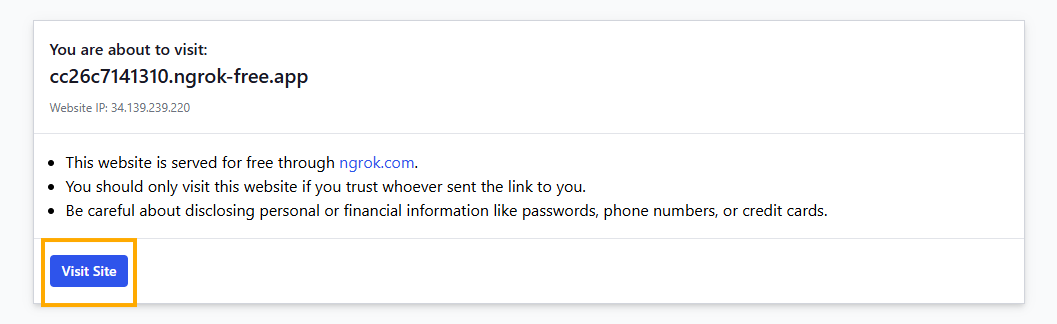

**2.** On this page, click "**Visit Site**" to be redirected to the MLFlow UI.<br>
**3.** Once you're in the MLFlow UI, you'll be able to see "**LLMOps_Demo**" under the experiments section <br>

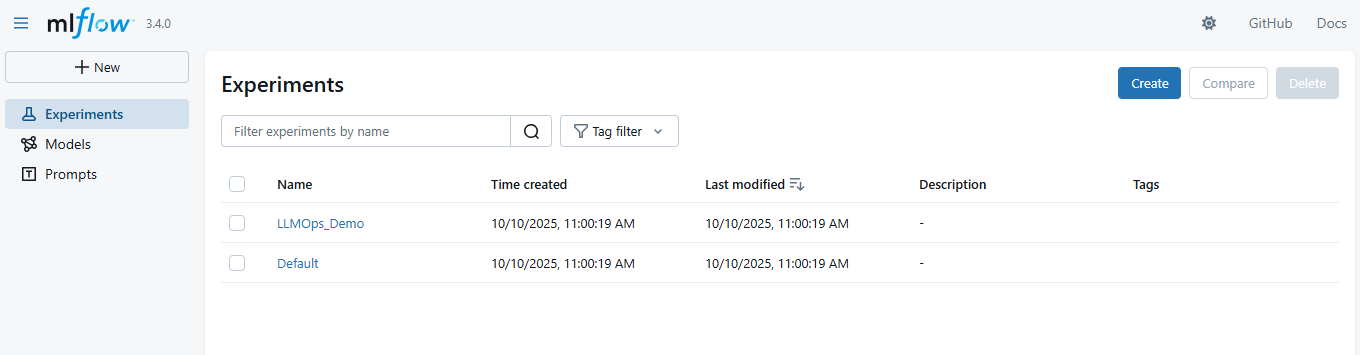

**4.** Click on "**LLMOps_Demo**" to see all the runs generated from the previous executions. <br>
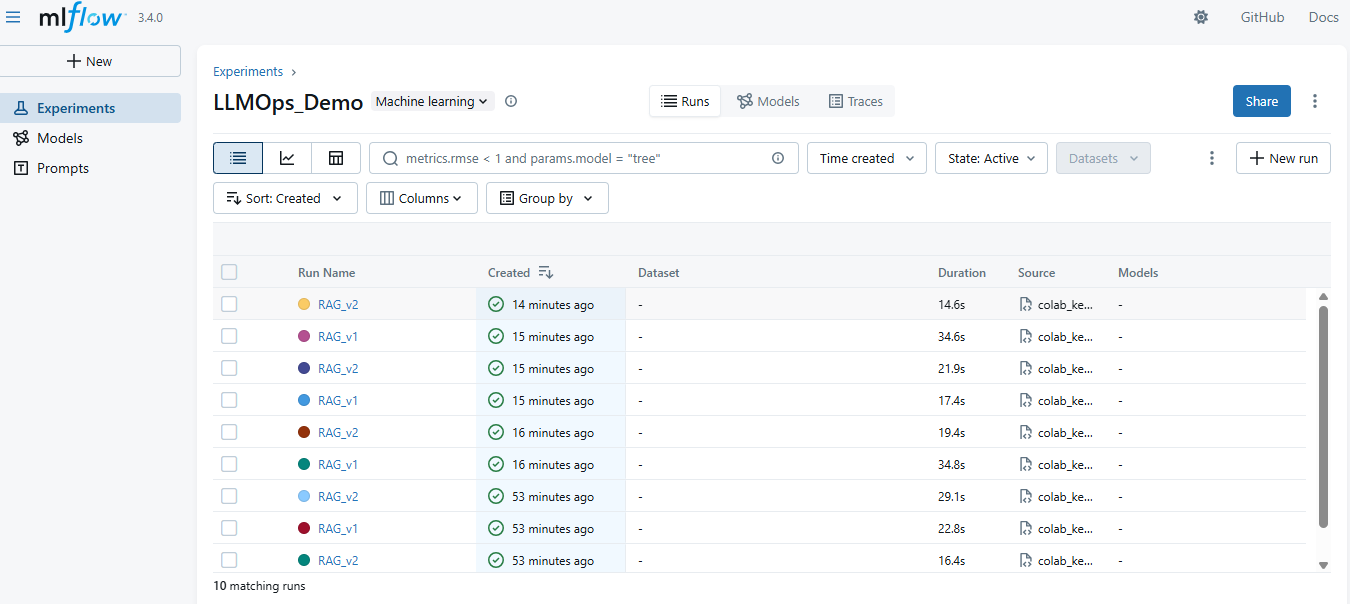

**5.** Click on each run to explore metrics, results and more. <br>

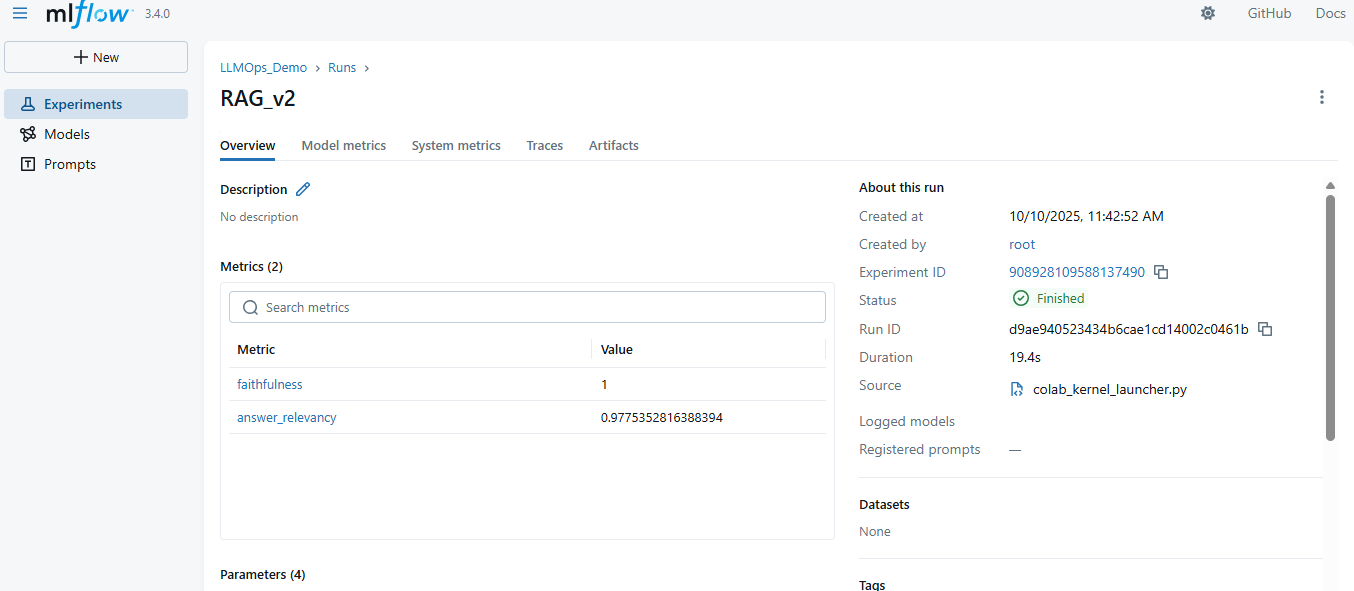


# Conclusion

* LLMOps brings structure and traceability. Applying LLMOps practices with tools like Prefect and MLflow ensures that AI pipelines are organized, monitored, and easier to improve.

* Prefect manages and automates tasks in the RAG pipeline-such as loading documents, creating embeddings, and generating answers-ensuring that each step runs in the correct sequence.

* MLflow records details of each pipeline run, including inputs, outputs, and performance metrics, making it easier to compare approaches and identify effective strategies.

* Combining RAG with LLMOps enhances efficiency and results.Integrating RAG with LLMOps supports experimentation, systematic performance tracking, and data-driven improvements for question-answering systems.

<font size=6 color="navyblue">Power Ahead!</font>
___